In [1]:
import numpy as np
import torch
from alphatoe import plot, game
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import torch.nn.functional as F

import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm

In [2]:
#pd csv
df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')

/tmp/ipykernel_118452/1104573101.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


In [3]:
df.head()

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [4]:
torch.set_grad_enabled(False)

def numpy(t):
    return t.cpu().numpy()


In [5]:
def ablate_one_head(head, seq, model):
    def hook(module, input, output):
        result = output.clone()
        result[:, :, head, :] = 0
        return result

    model.cfg.use_attn_result = True
    try:
        handle = model.blocks[0].attn.hook_result.register_forward_hook(hook)
        logits = model(torch.tensor(seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits

def plot_ablate_one_head(head, seq):
    plt.figure(figsize=(14, 5))

    logits = ablate_one_head(head, seq)
    preds = torch.softmax(logits, axis=-1)

    plt.subplot(1, 2, 1)
    plt.yticks(np.arange(10), labels=seq)
    plt.imshow(numpy(logits)[0], cmap="jet")
    plt.yticks(np.arange(10))
    plt.ylabel("Position", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Logits w/ pos embed", fontsize=20)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.yticks(np.arange(10), labels=seq)
    plt.imshow(numpy(preds)[0], cmap="jet")
    plt.yticks(np.arange(10))
    plt.ylabel("Position", fontsize=15)
    plt.xlabel("Predicted token", fontsize=15)
    plt.title("Preds w/ pos embed", fontsize=20)
    plt.colorbar()

    plt.suptitle(str(head), fontsize=20)

    plt.show()
    

loss_fn = F.cross_entropy


def head_ablated_loss(data, head, model):
    data_size = data.shape[0]
    target = einops.repeat(
        torch.tensor([0.0] * 9 + [1.0]),
        "logit_dim -> data_size logit_dim",
        data_size=data_size,
    ).to("cuda")
    logits = ablate_one_head(head, data, model)[:, -1, :]
    loss = F.cross_entropy(logits, target, reduction="none")
    loss.to("cpu").detach().numpy()
    return loss

heads = [0,1,2,3,4,5,6,7]

In [6]:
weights_two_head = torch.load("../scripts/models/2 head model proper dhead-20231014-201142.pt")
with open("../scripts/models/2 head model proper dhead-20231014-201142.json", "r") as f:
    args= json.load(f)
model_cfg = HookedTransformerConfig(
        n_layers=args["n_layers"],
        n_heads=args["n_heads"],
        d_model=args["d_model"],
        d_head=args["d_head"],
        d_mlp=args["d_mlp"],
        act_fn=args["act_fn"],
        normalization_type=args["normalization_type"],
        d_vocab=11,
        d_vocab_out=10,
        n_ctx=10,
        init_weights=True,
        device=args["device"],
        seed=args["seed"])

model_two_head =  HookedTransformer(model_cfg)
model_two_head.load_state_dict(weights_two_head)


<All keys matched successfully>

In [7]:
heads = [0,1]
# long run time
batch_restarts = (
    [0]
    + [df.loc[df["steps till end state"] == i].index[0] for i in [6, 7, 8, 9]]
    + [len(df)]
)
batch_size = 4096
df_ablation_two_head_losses = pd.DataFrame(columns=["moves played"] + heads)
with torch.no_grad():
    for head in tqdm(heads):
        head_losses = []
        for j in tqdm(range(len(batch_restarts) - 1)):
            batch_size = min(batch_restarts[j + 1], batch_size)
            for i in range(batch_restarts[j], batch_restarts[j + 1], batch_size):
                batch_gap = batch_restarts[j + 1] - i
                batch_size = batch_gap if batch_gap < batch_size else batch_size
                games = torch.stack(
                    [
                        torch.tensor([10] + eval(game))
                        for game in df["moves played"].iloc[i : i + batch_size]
                    ]
                ).to("cuda")
                loss = head_ablated_loss(games, head, model_two_head)
                head_losses.append(loss)
        inter = [
            loss.item()
            for loss in torch.cat(
                [torch.flatten(batch_losses) for batch_losses in head_losses]
            )
        ]

        df_ablation_two_head_losses[head] = inter

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_118452/1889970134.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))
100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


In [8]:
df_ablation_two_head_losses["first win condition"] = df['first win condition']

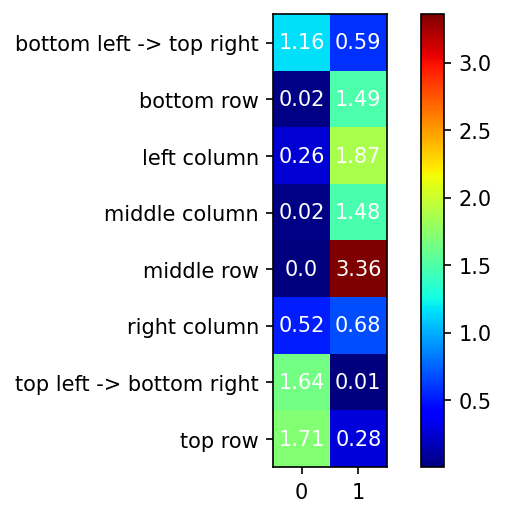

In [10]:
grouped_two_head = df_ablation_two_head_losses.groupby(["first win condition"])
plt.imshow(grouped_two_head.mean(), cmap="jet", interpolation="nearest")
plt.colorbar()
# legend
plt.xticks(heads, labels=grouped_two_head.mean().columns)
# yticks
plt.yticks(np.arange(0, 8), labels=grouped_two_head.mean().index)
# dpi
plt.rcParams["figure.dpi"] = 150
#add number labels in two grid
for i in range(0, 8):
    for j in range(0, 2):
        plt.text(j, i, grouped_two_head.mean().iloc[i, j].round(2), ha="center", va="center", color="w")